# Understanding the Amazon rainforest from space

Overview of Assignment
There are three types of tags in this assignment:
<br>
1) Weather (Cloudly, Partly Cloudy, Hazy, Clear) - every item has only one of these ones
<br>
2) Easy to identify tags Primary (forest), agricultural, habitation, roads, water, cultivation, bare ground,
<br>
3) Hard Labels - Slash & Burn, selective logging, blooms, and mine types
<br>

Given we are mostly interested in being able to tell where deforestation is occuring, we will simplify the land tags into naturally occuring phenomena 



In [1]:
##Create Libraries [Requires cleaning]
### Required libraries

import numpy as np # linear algebra
import pandas as pd 
from collections import Counter, defaultdict
from subprocess import check_output
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import scipy.stats
import seaborn as sns
import cv2
import plotly.offline as py
py.init_notebook_mode(connected=True)

import plotly.graph_objs as go
import plotly.tools as tls
import random
import math
# from osgeo import gdal
from skimage import io
#import imageio
from sklearn import preprocessing

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from skimage import transform
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')


C:\Users\Elle\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

C:\Users\Elle\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.



In [2]:
##Hi june - We didn't build this so please don't count the design in our marking. 
# It's just being used to improve the extraction of accuracy of pictures with haze.

def DarkChannel(im,sz):
    b,g,r = cv2.split(im)
    dc = cv2.min(cv2.min(r,g),b);
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
    dark = cv2.erode(dc,kernel)
    return dark

def AtmLight(im,dark):
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000),1))
    darkvec = dark.reshape(imsz,1);
    imvec = im.reshape(imsz,3);

    indices = darkvec.argsort();
    indices = indices[imsz-numpx::]

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
        atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx;
    return A

def TransmissionEstimate(im,A,sz):
    omega = 0.95;
    im3 = np.empty(im.shape,im.dtype);

    for ind in range(0,3):
        im3[:,:,ind] = im[:,:,ind]/A[0,ind]

    transmission = 1 - omega*DarkChannel(im3,sz);
    return transmission

def Guidedfilter(im,p,r,eps):
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
    cov_Ip = mean_Ip - mean_I*mean_p;

    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
    var_I   = mean_II - mean_I*mean_I;

    a = cov_Ip/(var_I + eps);
    b = mean_p - a*mean_I;

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

    q = mean_a*im + mean_b;
    return q;

def TransmissionRefine(im,et):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY);
    gray = np.float64(gray)/255;
    r = 60;
    eps = 0.0001;
    t = Guidedfilter(gray,et,r,eps);

    return t;

def Recover(im,t,A,tx = 0.1):
    res = np.empty(im.shape,im.dtype);
    t = cv2.max(t,tx);

    for ind in range(0,3):
        res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]

    return res


def remove_haze(image):
    src = cv2.imread(image);
    I = src.astype('float64')/255;
    dark = DarkChannel(I,15);
    A = AtmLight(I,dark);
    te = TransmissionEstimate(I,A,15);
    t = TransmissionRefine(src,te);
    J = Recover(I,t,A,0.1);
    return J


## Read the Satellite Images
There're 2 image formats provided for training and testing: jpg and tif. The tif format contains additional dimensions outside of the jpg RGB dimensional constraints which enable us to extract the infrared spectrum.

In [5]:
##set path
train_path1='train_jpg/'
train_path2='train_tif/'
test_path1='test_jpg/'

#obtain training labels
df = pd.read_csv('train_labels.csv')
##get the length of the data size
sample_size=df.shape[0]

#retrieve jpg data - compress from 256x256 to 64x64 for faster training [remove constraint in final product]
data_jpgs=np.zeros((sample_size,64,64,11))

def read_image(image_str):
    ##read the image
    read_img = plt.imread(train_path1+image_str)
    read_img=read_img[:,:,:3]
    ##reduce the image size for smaller processing
    jpg_img=transform.resize(read_img, (64,64,3))
    ##use the remove haze image to better identify features
    haze_img=remove_haze(train_path1+image_str)
    haze_img=transform.resize(haze_img, (64,64,3))
    ##create a matrix for both features
    clean_img=np.zeros((64,64,6))
    clean_img[:,:,:3]=jpg_img
    clean_img[:,:,3:6]=haze_img
    return clean_img

for i in range(sample_size):
    data_jpgs[i,:,:,0:6]=read_image("train_"+str(i)+".jpg")

In [93]:
##add - greyscale information for both normal images
data_jpgs[:,:,:,6]=data_jpgs[:,:,:,0]*0.2989+data_jpgs[:,:,:,1]*0.5870+data_jpgs[:,:,:,2]*0.1140
##add - greyscale information for haze images
data_jpgs[:,:,:,7]=data_jpgs[:,:,:,3]*0.2989+data_jpgs[:,:,:,4]*0.5870+data_jpgs[:,:,:,5]*0.1140

In [90]:
def extract_identifier(image_str):
    img = io.imread(train_path2+image_str)
    small_img=transform.resize(img, (64,64,4))
    return small_img
#4th dimension of GeoTiff contains near-infrared spectrum
tif_data=np.zeros((sample_size,64,64,4))
for i in range(sample_size):
    tif_data[i,:,:,:]=extract_identifier("train_"+str(i)+".tif")

In [92]:
# Add the needed data tif data to the main frame
#extract, vegetation probabilities and water information - show how the data
#This take the blue pixels, subtracts the infrared, and divides by the total to indicate water
data_jpgs[:,:,:,8]=(tif_data[:,:,:,0]-tif_data[:,:,:,3])/(tif_data[:,:,:,0]+tif_data[:,:,:,3])
#This take the infrared pixels, subtracts the red, and divides by the total to indicate vegetation
data_jpgs[:,:,:,9]=(tif_data[:,:,:,3]-tif_data[:,:,:,2])/(tif_data[:,:,:,3]+tif_data[:,:,:,2]) 
#This take the infrared pixels, subtracts the green, and divides by the total just in case 
# green and infrared have an interesting relationship
data_jpgs[:,:,:,10]=(tif_data[:,:,:,3]-tif_data[:,:,:,1])/(tif_data[:,:,:,3]+tif_data[:,:,:,1]) 


(40479, 64, 64, 11)
(64, 64, 11)


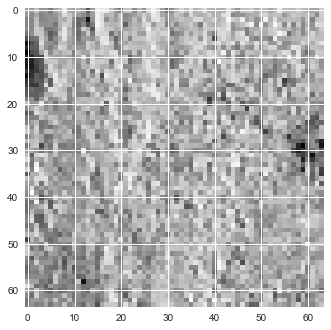

In [87]:
print(data_jpgs.shape)
image_to_show=data_jpgs[18753]
print(image_to_show.shape)
plt.imshow(image_to_show[:,:,7])

## Label Analysis, Visualization, & Correlation

Each picture can have multiple labels. There is a varying visibility between the images.  

As a result, visibility is a key feature which needs to be identified and cleared for additional feature identification. Visibility is categorized in levels by cloud cover - haze, partly cloudy, cloudy and clear.

Primary label refers to primary rainforest. Water refers to rivers and large water bodies.

Human interference & civilization can be categorized into road, agriculture, habitation, selective logging, artisal mine, slash burn, conventional mine, etc. Theare are also rare natural tags like blooming and blow down, which we not include in this analysis.

Since the goal of our project is to automatically categorize landscape, which prepares for the prediction of rainforest diminishing rate, we categorize the original labels into three main areas:
* Weather due to cloud cover (haze, partly cloudy, haze)
* Water
* Primary
* Other tags

All other tags will be removed to reduce the complexity.


In [142]:
#Add a column for land tags
def apply_land(land_tags):
    land_list=[]
    other_tags=['habitation','bare_ground','cultivation','agriculture','blow_down', 'conventional_mine', 'selective_logging', 'slash_burn', 'artisinal_mine', 'blooming']
    if 'primary' in land_tags:
        land_list.append('primary')
    if 'water' in land_tags:
        land_list.append("water")
    other_present=0
    for i in other_tags:
        if i in land_tags:
            other_present=1
            break
    if other_present==1:
        land_list.append('other')
    if land_list == []:
        land_list.append('none')
    return ' '.join(land_list)
df['land'] = df.tags.map(apply_land)
df_land = df['land'].tolist()

#Add a column for weather tags
def apply_weather(weather):
    if 'partly_cloudy' in weather:
        return 'partly_cloudy'
    elif 'cloudy' in weather:
        return 'cloudy'
    elif 'haze' in weather:
        return 'haze'
    else:
        return 'clear'
df['weather'] = df.tags.map(apply_weather)
df_weather = df['weather'].tolist()


In [143]:
#After adding three more columns, our dataframe looks like this
print(df.iloc[:5])

  image_name                                       tags                 land  \
0    train_0                               haze primary              primary   
1    train_1            agriculture clear primary water  primary water other   
2    train_2                              clear primary              primary   
3    train_3                              clear primary              primary   
4    train_4  agriculture clear habitation primary road        primary other   

  weather               tags_split  
0    haze                [primary]  
1   clear  [primary, water, other]  
2   clear                [primary]  
3   clear                [primary]  
4   clear         [primary, other]  


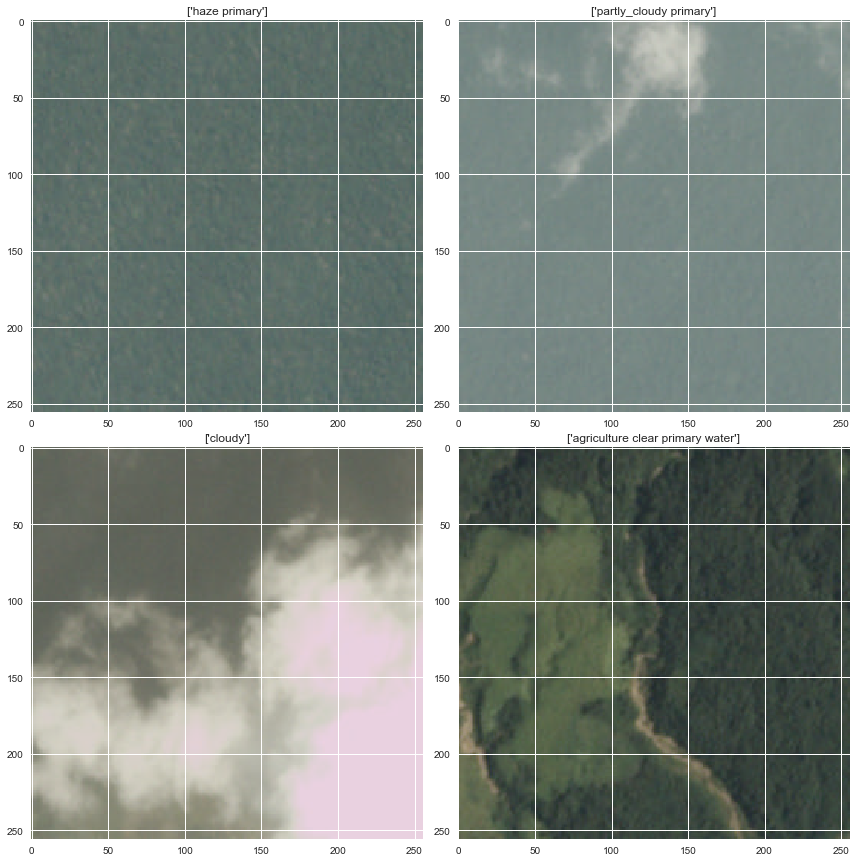

In [18]:
#Graph demonstration of four weather type
plt.figure(figsize=(12,12))
weather_list = ["haze","partly_cloudy","cloudy","clear"]
j = 0
for i in weather_list:
    plt.subplot(2,2,j+1)
    image_number = df.loc[df['weather'] == i][:1]['image_name'].values
    image_path = train_path1+image_number+".jpg"
    plt.imshow(plt.imread(image_path[0]))
    plt.tight_layout()
    plt.title(str(df[df.image_name == image_number[0]].tags.values))  
    j += 1

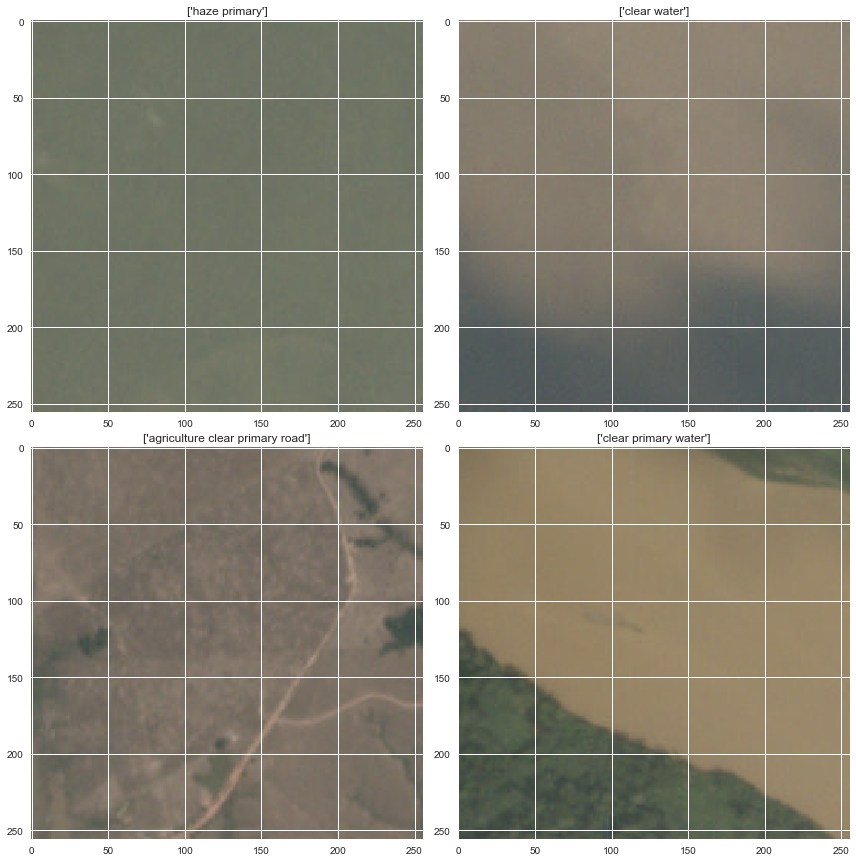

In [19]:
#Graph demonstration of three land type
plt.figure(figsize=(12,12))
land_list = ["primary","water","primary other", "primary water"]
j = 0
for i in land_list:
    plt.subplot(2,2,j+1)
    image_number = df.loc[df['land'] == i][3:4]['image_name'].values
    image_path = train_path1+image_number+".jpg"
    plt.imshow(plt.imread(image_path[0]))
    plt.tight_layout()
    plt.title(str(df[df.image_name == image_number[0]].tags.values))  
    j += 1

### Observation
Image visibility varies. Images with out haze and cloud are much easier to identify the land type. 

Each picture has multiple labels except for 'Cloudy' tag, which does not appear with other labels. 'Water' is sometimes hard to identify in the images.

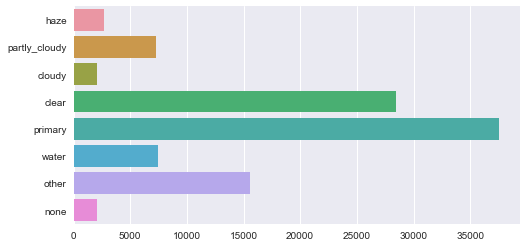

In [37]:
#Display counts of weather and land labels
df["combined_tags"] = df["weather"] + " " + df["land"]
labels = df['combined_tags'].apply(lambda x: x.split(' '))
all_tags = [item for sublist in list(labels.values) for item in sublist]
labels_s = pd.Series(all_tags).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=labels_s, y=labels_s.index, orient='h', order = ['haze', 'partly_cloudy', 'cloudy', 'clear','primary', 'water', 'other', 'none'])

### Observation
The majority pictures have 'Clear' weather and 'Primary' land type. 

There are very few pictures with no tag whatsoever

In [22]:
#Display correlation between labels 
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

com = np.zeros([len(counts)]*2)
for i, l in enumerate(list(counts.keys())):
    for i2, l2 in enumerate(list(counts.keys())):
        c = 0
        cy = 0
        for row in labels.values:
            if l in row:
                c += 1
                if l2 in row: cy += 1
        com[i, i2] = cy / c

data=[go.Heatmap(z=com, x=list(counts.keys()), y=list(counts.keys()))]
layout=go.Layout(height=600, width=600, title='Co-occurence matrix of training labels')
fig=dict(data=data, layout=layout)
py.iplot(data, filename='train-com')

### Observation

To do - Wei can you order the tags so weather and land tags are next to each other.

'Primary' land type has high correlation with all weather tags except for "Cloudy". Most "Cloudy" pictures have "Other" land type. 

"Water" land type is highly correlated with "Clear" tag.

Static features including volume of colours can be extracted using the following logic:
* Green = Trees/Vegetation
* Blue = Water
* White = Clouds

The higher the pixel value, the higher the intensity of the colors. Variance in the colors indicate feature differences in the image.

In [97]:
##extract_basic-stats about image
stats_flat=np.reshape(data_jpgs,(data_jpgs.shape[0],4096,11))
jpg_stats=np.zeros((stats_flat.shape[0],198))

print(jpg_stats.shape)
##extract normal stats
for i in range(stats_flat.shape[0]):
    jpg_stats[i,:11]=np.average(stats_flat[i,:,],axis=0)
    jpg_stats[i,11:22]=np.var(stats_flat[i,:,],axis=0)
    jpg_stats[i,22:33]=np.std(stats_flat[i,:,],axis=0)
    kurt_skew=np.zeros((22,))
    jpg_stats[i,33:55]=kurt_skew
    for j in range(11):
        kurt_skew[j]=scipy.stats.kurtosis(data_jpgs[i,:,:,j].ravel())
        kurt_skew[j+11]=scipy.stats.skew(data_jpgs[i,:,:,j].ravel())
    for j in range(11):
        t=np.array(np.histogram(data_jpgs[i,:,:,j],bins=20, range=(-1,1))[0])
        try:
            jpg_stats[i,j*20+55:j*20+75].shape=t
        except:
            pass
        

(40479, 198)


The mean color intensity is:  0.32
The mean color intensity is with haze reduction:  0.49
The mean color variance is:  0.003
The mean color variance is:  0.214


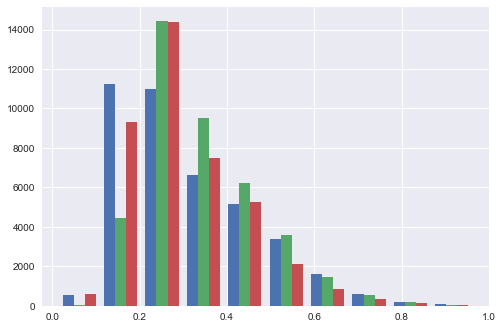

In [108]:
print('The mean color intensity is: ', round(jpg_stats[:,0:3].mean(), 2))
print('The mean color intensity is with haze reduction: ', round(jpg_stats[:,3:6].mean(), 2))
plt.hist(jpg_stats[:,0:3])

print('The mean color variance is: ', round(jpg_stats[:,11:14].mean(), 3))
print('The mean color variance is: ', round(jpg_stats[:,14:17].mean(), 3))
# print('The mean color variance for haze reduced is: ', round(jpg_stats[:,14:17].mean(), 3))



Edge detection in the images can be analyzed using the following parameters:
* Laplacian outputs the color gradients in the images
* Sobel outputs the edges of the color gradients in the x or the y directions

The following distributions shows that majority of the pictures may not have large color gradients. As a result, many of the images are dominated by their respective label components and relatively few satellite images contain edges.

In [113]:
##extract edge data from images
edge_stats=np.zeros((stats_flat.shape[0],6))
for i in range(stats_flat.shape[0]):
    img=data_jpgs[i,:,:,3:6]
    grey=data_jpgs[i,:,7]
    edge_stats[i,0]=cv2.Laplacian(img, cv2.CV_64F).mean()
    edge_stats[i,1]=cv2.Laplacian(img, cv2.CV_64F).var()
    edge_stats[i,2]=cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5).var()
    edge_stats[i,3]=cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5).mean()
    edge_stats[i,4]=cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5).mean()
    edge_stats[i,5]=cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5).var()


(array([2.0000e+00, 4.0000e+00, 4.8000e+01, 5.5900e+02, 1.8670e+04,
        2.0043e+04, 6.0500e+02, 6.5000e+01, 3.0000e+00, 1.0000e+00]),
 array([-2.18856911e-03, -1.75269831e-03, -1.31682751e-03, -8.80956712e-04,
        -4.45085912e-04, -9.21511183e-06,  4.26655688e-04,  8.62526488e-04,
         1.29839729e-03,  1.73426809e-03,  2.17013889e-03]),
 <a list of 10 Patch objects>)

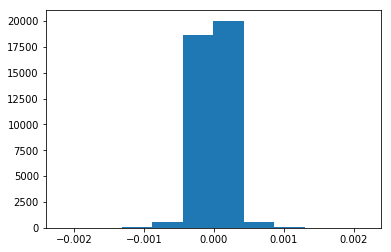

In [66]:
plt.hist(edge_stats[:,0])

(array([1.0000e+00, 9.0000e+00, 7.9000e+01, 3.6600e+02, 3.4070e+03,
        3.4277e+04, 1.5600e+03, 2.4400e+02, 5.0000e+01, 7.0000e+00]),
 array([-1.50888233, -1.22762907, -0.9463758 , -0.66512254, -0.38386928,
        -0.10261601,  0.17863725,  0.45989051,  0.74114377,  1.02239704,
         1.3036503 ]),
 <a list of 10 Patch objects>)

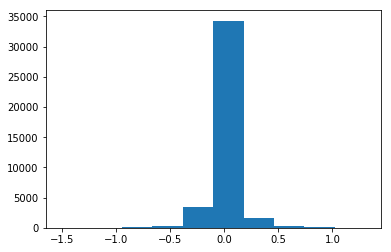

In [67]:
plt.hist(edge_stats[:,3:4])

## Split training and test sets [jpg]
The first 39000 samples will be allocated to the training set while the remaining samples will be allocated to the test set. Randomization is not required since prior ordering is unknown.

## Infrared spectrum analysis

Extracting the near-infrared spectrum in the images(tif format) enables the identification of "hot" surfaces with varying degrees of heat such as: 
1. Civilization
2. Vegetation
3. Large bodies of water

Water features can be identified by removing the blue frequency from the near-infrared spectrum: (B-IRR)/(B+IRR) 

Vegetation features can be identified by removing green frequency from the near-infrared spectrum: (IRR-R)/(R+IRR). 

We note that in our data_jpgs analysis, the infrared 

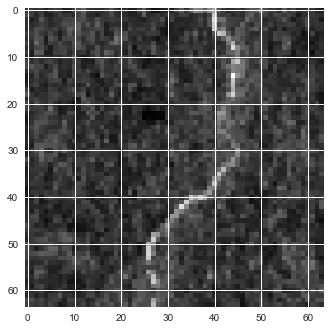

In [114]:
#Sample vegetation feature identification
plt.imshow(data_jpgs[18573,:,:,9])

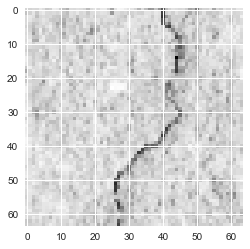

In [26]:
#Sample water feature identification
plt.imshow(water_tif[18573])

In [116]:
combined_matrix=np.zeros((sample_size,204))
combined_matrix[:,0:198]=jpg_stats
combined_matrix[:,198:234]=edge_stats


## Split training and test sets [tif]
The first 30000 samples will be allocated to the training set while the remaining samples will be allocated to the test set. Randomization is required! Someone needs to fix this!!!!!!!!

In [158]:
#Create test and training datatrain_labels=np.array(df_tags[:30000])
train_labels_weather=np.array(df_weather[:39000])
train_labels_land=np.array(df_land[:39000])
train_data=combined_matrix[:39000]

test_labels_weather=np.array(df_weather[39000:])
test_labels_land=np.array(df_land[39000:])
test_data=combined_matrix[39000:]

## Weather feature identification

Weather feature identification is being performed for cloud and haze removal. This facilitates the successive water, land and primary feature identification.

In [ ]:
#Logistic Regression
def logistic_regression(training_data, training_labels, testing_data, testing_labels):
    model =LogisticRegression()
    model.fit(training_data, training_labels)
    LG_predictions=model.predict(testing_data)
    print('Logistic Regression: ' + classification_report(testing_labels,LG_predictions))
    classifier_chain(model, training_data, training_labels, testing_data, testing_labels)
    
logistic_regression(train_data, train_labels, test_data, test_labels)

In [159]:
def dec_tree_model(maxs,data_train,labels_train,data_test,labels_test):
    #set the model to take in the k value
    model = DecisionTreeClassifier(min_samples_leaf=20, max_depth=maxs)
    #fit per the train data
    model.fit(data_train, labels_train)
    dev_predictions2=model.predict(data_test)
    #set by the test data
#     score = model.score(data_test, labels_test)
    #print the score prettily
    return classification_report(labels_test,dev_predictions2), model
for i in [5,10,20,50,100]:
    print("Decision Tree: K-branch levels " + str(i))
    classification_rpt, model = dec_tree_model(i,train_data,train_labels_weather,test_data,test_labels_weather)
    print(classification_rpt)


Decision Tree: K-branch levels 5
               precision    recall  f1-score   support

        clear       0.86      0.96      0.90      1047
       cloudy       0.61      0.74      0.67        69
         haze       0.79      0.45      0.58        97
partly_cloudy       0.77      0.48      0.59       266

  avg / total       0.82      0.83      0.82      1479

Decision Tree: K-branch levels 10
               precision    recall  f1-score   support

        clear       0.90      0.95      0.93      1047
       cloudy       0.75      0.70      0.72        69
         haze       0.80      0.55      0.65        97
partly_cloudy       0.79      0.72      0.75       266

  avg / total       0.87      0.87      0.87      1479

Decision Tree: K-branch levels 20
               precision    recall  f1-score   support

        clear       0.91      0.95      0.93      1047
       cloudy       0.70      0.72      0.71        69
         haze       0.78      0.59      0.67        97
partly_cloud

In [162]:
def random_forest_model(maxs,data_train,labels_train,data_test,labels_test):
    #set the model to take in the k value
    model = RandomForestClassifier(n_estimators=20, max_depth=maxs, min_samples_leaf=2)
     #fit per the train data
    model.fit(data_train, labels_train)
    dev_predictions2=model.predict(data_test)
    #set by the test data
#     score = model.score(data_test, labels_test)
    #print the score prettily
    return classification_report(labels_test,dev_predictions2), model

for i in [5,10,20,50,75]:
    print("Random Forest: K-branch levels " + str(i))
    classification_rpt, model = random_forest_model(i,train_data,train_labels_weather,test_data,test_labels_weather)
    print(classification_rpt)
#     print('One Vs. Rest K-branch levels ' + str(i))
#     classifier_chain(model, train_data, train_labels, test_data, test_labels)

Random Forest: K-branch levels 5
               precision    recall  f1-score   support

        clear       0.86      0.97      0.91      1047
       cloudy       0.82      0.71      0.76        69
         haze       0.78      0.53      0.63        97
partly_cloudy       0.87      0.56      0.68       266

  avg / total       0.85      0.85      0.84      1479

Random Forest: K-branch levels 10
               precision    recall  f1-score   support

        clear       0.89      0.98      0.93      1047
       cloudy       0.76      0.70      0.73        69
         haze       0.84      0.53      0.65        97
partly_cloudy       0.90      0.70      0.79       266

  avg / total       0.88      0.89      0.88      1479

Random Forest: K-branch levels 20
               precision    recall  f1-score   support

        clear       0.91      0.98      0.95      1047
       cloudy       0.81      0.70      0.75        69
         haze       0.84      0.59      0.69        97
partly_cloud

In [177]:
sel_weather_model = RandomForestClassifier(n_estimators=10, max_depth=20)
     #fit per the train data
sel_weather_model.fit(train_data, train_labels_weather)
dev_predictions2=sel_weather_model.predict(test_data)
print(classification_report(test_labels_weather,dev_predictions2))
print(confusion_matrix(test_labels_weather,dev_predictions2))

               precision    recall  f1-score   support

        clear       0.90      0.97      0.94      1047
       cloudy       0.83      0.72      0.78        69
         haze       0.85      0.62      0.71        97
partly_cloudy       0.88      0.74      0.80       266

  avg / total       0.89      0.90      0.89      1479

[[1017    2    8   20]
 [  10   50    3    6]
 [  31    5   60    1]
 [  66    3    0  197]]


In [ ]:
This is now a very accurate model.

# Land Models - single label models

In [167]:
def random_forest_model(maxs,data_train,labels_train,data_test,labels_test):
    #set the model to take in the k value
    model = RandomForestClassifier(n_estimators=20, max_depth=maxs, min_samples_leaf=2)
     #fit per the train data
    model.fit(data_train, labels_train)
    dev_predictions2=model.predict(data_test)
    #set by the test data
#     score = model.score(data_test, labels_test)
    #print the score prettily
    return classification_report(labels_test,dev_predictions2), model

for i in [5,10,20,50,75,100]:
    print("Random Forest: K-branch levels " + str(i))
    classification_rpt, model = random_forest_model(i,train_data,train_labels_land,test_data,test_labels_land)
    print(classification_rpt)
#     print('One Vs. Rest K-branch levels ' + str(i))
#     classifier_chain(model, train_data, train_labels, test_data, test_labels)

Random Forest: K-branch levels 5
                     precision    recall  f1-score   support

               none       0.75      0.74      0.74        69
              other       0.00      0.00      0.00        21
            primary       0.80      0.85      0.82       722
      primary other       0.59      0.79      0.67       415
      primary water       0.61      0.09      0.15       126
primary water other       0.50      0.29      0.37       114
              water       0.25      0.12      0.17         8
        water other       0.00      0.00      0.00         4

        avg / total       0.68      0.70      0.67      1479

Random Forest: K-branch levels 10
                     precision    recall  f1-score   support

               none       0.75      0.78      0.77        69
              other       0.00      0.00      0.00        21
            primary       0.83      0.89      0.86       722
      primary other       0.63      0.79      0.70       415
      primary 

In [133]:
#the model does extremely badly on picking up models with water - 
#it is fairly efficient at picking up primar and primary tags vs other

In [170]:
sel_land_model = RandomForestClassifier(n_estimators=50, max_depth=100, min_samples_leaf=5)
     #fit per the train data
sel_land_model.fit(train_data, train_labels_land)
dev_predictions2=sel_land_model.predict(test_data)
print(classification_report(test_labels_land,dev_predictions2))
print(confusion_matrix(test_labels_land,dev_predictions2))

                     precision    recall  f1-score   support

               none       0.75      0.80      0.77        69
              other       0.00      0.00      0.00        21
            primary       0.83      0.93      0.88       722
      primary other       0.69      0.78      0.73       415
      primary water       0.57      0.33      0.41       126
primary water other       0.50      0.24      0.32       114
              water       0.29      0.25      0.27         8
        water other       0.00      0.00      0.00         4

        avg / total       0.72      0.75      0.73      1479

[[ 55   0   5   6   0   1   2   0]
 [  0   0   2  18   1   0   0   0]
 [  6   0 669  35   7   3   2   0]
 [  4   0  76 322   4   9   0   0]
 [  3   0  40  28  41  13   1   0]
 [  1   1  10  58  17  27   0   0]
 [  4   0   0   1   1   0   2   0]
 [  0   0   0   2   1   1   0   0]]


This is clearly not a good model, as by forcing the labels to separate we lose all the predictive power contained in other labels. I.e. what's in a primary water image, will hopefully help use to predict whats in a water other tag as well.

# Multi-label land methods

In [171]:
df['tags_split'] = df['land'].map(lambda row: row.split(" "))
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df['tags_split'])

train_labels=labels[:39000]

test_labels=labels[39000:]

In [174]:
ovr=OneVsRestClassifier(DecisionTreeClassifier(max_depth=50, min_samples_leaf=10)).fit(train_data,train_labels)
ovr_predict=ovr.predict(test_data)
print(classification_report(test_labels,ovr_predict))

             precision    recall  f1-score   support

          0       0.77      0.68      0.72        69
          1       0.82      0.77      0.79       554
          2       0.97      0.98      0.97      1377
          3       0.61      0.53      0.57       252

avg / total       0.89      0.87      0.88      2252



In [176]:
ovr=OneVsRestClassifier(RandomForestClassifier(n_estimators=50,max_depth=50, min_samples_leaf=2)).fit(train_data,train_labels)
ovr_predict=ovr.predict(test_data)
print(classification_report(test_labels,ovr_predict))

             precision    recall  f1-score   support

          0       0.79      0.65      0.71        69
          1       0.86      0.78      0.82       554
          2       0.97      0.99      0.98      1377
          3       0.77      0.49      0.60       252

avg / total       0.91      0.87      0.89      2252



The model is now doing a better job at picking up the rare labels, though it struggles a lot with the water label. 
It is mostly good at detecting the primary label because it appears so often, though it does a relatively good job with the other label, and the none label (which should mostly be used for cloudly image.

In [ ]:
from sklearn.metrics import jaccard_similarity_score
def ovr(estimator, training_data, training_labels, testing_data, testing_labels):
    mlb = MultiLabelBinarizer()
    training_labels2 = mlb.fit_transform(training_labels)
    testing_labels2=mlb.fit_transform(testing_labels)
    ovr=OneVsRestClassifier(estimator)
    ovr.fit(training_data,training_labels2)
    ovr_predict=ovr.predict(testing_data)
    print('OVR Classification Report: '+ classification_report(testing_labels2,ovr_predict))
    print('OVR Jaccard similarity score: '+ str(jaccard_similarity_score(testing_labels2, ovr_predict)))
    return jaccard_similarity_score(testing_labels2, ovr_predict)

def classifier_chain(estimator, training_data, training_labels, testing_data, testing_labels):
    ovr_jaccard_score = ovr(estimator, training_data, training_labels, testing_data, testing_labels)
    mlb = MultiLabelBinarizer()
    training_labels2 = mlb.fit_transform(training_labels)
    testing_labels2=mlb.fit_transform(testing_labels)
    chains = [ClassifierChain(estimator, order='random', random_state=i)
              for i in range(4)]
              #for i in range(training_labels2.shape[1])]
    #return chains
    for chain in chains:
        chain.fit(training_data, training_labels2)

    pred_chains = np.array([chain.predict(testing_data) for chain in
                              chains])
    
    chain_jaccard_scores = [jaccard_similarity_score(testing_labels2, pred_chain >= .5)
                            for pred_chain in pred_chains]

    pred_ensemble = pred_chains.mean(axis=0)
    ensemble_jaccard_score = jaccard_similarity_score(testing_labels2, pred_ensemble >= .5)
    
    model_scores = [ovr_jaccard_score] + chain_jaccard_scores
    print(model_scores)
    model_scores.append(ensemble_jaccard_score)
    
    model_names = ('Independent',
                   'Chain 1',
                   'Chain 2',
                   'Chain 3',
                   'Chain 4',
                   #'Chain 5',
                   #'Chain 6',
                   #'Chain 7',
                   #'Chain 8',
                   #'Chain 9',
                   #'Chain 10',
                   #'Chain 11',
                   #'Chain 12',
                   #'Chain 13',
                   #'Chain 14',
                   'Ensemble')

    x_pos = np.arange(len(model_names))

    # Plot the Jaccard similarity scores for the independent model, each of the
    # chains, and the ensemble (note that the vertical axis on this plot does
    # not begin at 0).

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.grid(True)
    ax.set_title('Classifier Chain Ensemble Performance Comparison')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_names, rotation='vertical')
    ax.set_ylabel('Jaccard Similarity Score')
    ax.set_ylim([min(model_scores) * .9, max(model_scores) * 1.1])
    colors = ['r'] + ['b'] * len(chain_jaccard_scores) + ['g']
    ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
    plt.tight_layout()
    plt.show()
    print('Ensemble Jaccard Similarity Score: ' + str(ensemble_jaccard_score))
    
#classifier_chain(LogisticRegression(), train_data, train_labels, test_data, test_labels)

The model does well at picking clear, cloudy, primary and not much else. To better identify roads, and water edge extraction may 
help. We're also not taking advantage of correlation with the model here.

Interestingly the model isn't picking too many false positives (i.e. precision), but is picking a lot of false negatives(i.e. recall). This suggests we need to build more features to pick up land masses, roads and waters. 


# Appendix - Features we tried but did not improve overall accuracy

## Principal component analysis (PCA)

PCA speeds up the training of features by choosing the minimum number of components such that 95% of the variance is retained.

A logistic regression model is used to further examine the prediction score.

In [ ]:
#PCA the training set to potentially reduce the size
pca = PCA(.95)

#train_data_jpgs = train_data_jpgs.reshape((len(train_labels_jpgs),train_data_jpgs.shape[0]*train_data_jpgs.shape[1]))
#test_data_jpgs = test_data_jpgs.reshape((len(test_labels_jpgs),test_data_jpgs.shape[0]*test_data_jpgs.shape[1]))
train_data_jpgs = train_data_jpgs.reshape(-1, 3)
test_data_jpgs = test_data_jpgs.reshape(-1, 3)

pca.fit(train_data_jpgs)

train_data_jpgs = pca.transform(train_data_jpgs)
test_data_jps = pca.transform(test_data_jpgs)

print('The PCA explained variance ratios for each component are: ', pca.explained_variance_ratio_)
print('The number of PCA components chosen are: ', pca.n_components_)


#Testing accuracy of logistic Regression with PCA for sample of 1000 images
# logisticRegr = LogisticRegression(solver = 'lbfgs')
# %time logisticRegr.fit(train_data_jpgs, train_labels_jpgs)
# logisticRegr.predict(test_data_jpgs[0:1000])
# print('The logistic regression score is:', logisticRegr.score(test_data_jpgs, test_labels_jpgs))

In [ ]:
train_labels_jpgs=np.array(df_tags[:30000])

train_data_jpgs=np.zeros((len(train_labels_jpgs),256,256,3))
for i in range(len(train_labels_jpgs)):
    train_data_jpgs[i,:,:,:]=read_image("train_"+str(i)+".jpg")

test_labels_jpgs=np.array(df_tags[30000:])

test_data_jpgs=np.zeros((len(test_labels_jpgs),256,256,3))
for i in range(len(test_labels_jpgs)):
    test_data_jpgs[i,:,:,:]=read_image("train_"+str(i)+".jpg")

## Feature prediction of clear components
Land and water can be extracted using canny edge detection or equivalent. The inputs are haze/cloud cleared train data+labels.

[Under construction]

In [ ]:
def road_water_canny(train_data, train_labels, test_data, test_labels):
##Testing water/road feature identification##
    #40479 images in df
    #13357 images with water and road tags in labels
    train_roadwater_data = [i for i, j in zip(train_data, train_labels) if 'water' in j or 'road' in j]
    train_roadwater_labels = [j for i, j in zip(train_data, train_labels) if 'water' in j or 'road' in j]
    

    
    train_images = []
    test_images = []
    
    feature_count = 0
    positive_test_img = []
    plt.figure(figsize=(12,12))
    
    for i, train_img in enumerate(train_roadwater_data):
        
        gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        cannyed_image = cv2.Canny(gray_image, 100, 200)
        
        try:
            plt.subplot(3,3,i+1)
            if i < 10:
                plt.imshow(cannyed_image)
                #plt.title(str(df[df.image_name == df_road_water_images[i]].tags.values))
        except:
            pass
        
        predicted_sum = sum(cannyed_image.flatten())
        
        if predicted_sum > 2.0:
            feature_count += 1
            positive_train_img.append(train_)
        
    positive_label_count = len([i for i, j in zip(train_roadwater_, positive_train_img) if i == j])
    
    return feature_count, positive_label_count
    
feature_count, positive_label_count = road_water_canny(train_data_jpg, train_labels_jpg, test_data_jpg, test_labels_jpg)
print('Total number of images with water/road boundary features', feature_count)
print('Correctly predicted labels', positive_label_count)
print('Accuracy is: ', positive_label_count/feature_count * 100, '%')
print('Remaining images with especially water labels may not have boundaries/features in water or contain too much cloud.')

Going forward we've got three clear priorities:

Improve the models we have now:
1) Improve the classifiers we have by running cross validation on the data, and setting up proper pipelines
2) Play with the statistics in the model to see if changing them produces better impacts (i.e. water prediction is only working a third of the time, can we improve it)
3) Try other kinds of multi-label models

Extract More features:
1) We've used a haze remover before to improve picture quality, and a two stage process will let us identify which pictures need it and then extract the land labels so we don't use any information.

Try Deep learning:
Image feature analysis is some what out of fashion, and most of the successful approaches to this on Kaggle used CNN. 
June if you could point us in the right direction for how to do this that would be awesome. We've run into memory issues, before using the statistical extraction approach.

Out of scope
Try Convultional Neural Networks
Ask June for help in Set-up